# Project 2. “Why did I get the flu?”. Deep sequencing, error control, p-value, viral evolution.

Lab notebook by Nikita Vyatkin

## Data source

Sequencing results are usually stored in the NCBI Sequence Read Archive, or SRA (it was previously known as the Short Read Archive, but with arrival of the new long-read NGS technologies, the name was appropriately updated). Our data was published there and labeled SRR1705851, so one can download it from the SRA FTP server:
http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/001/SRR1705851/


In [2]:
! wget -P raw_data http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/001/SRR1705851/SRR1705851.fastq.gz

--2022-11-07 12:23:06--  http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/001/SRR1705851/SRR1705851.fastq.gz
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.138|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19217176 (18M) [application/x-gzip]
Saving to: ‘raw_data/SRR1705851.fastq.gz’

SRR1705851.fastq.gz 100%[===================>]  18,33M   828KB/s    in 23s     

2022-11-07 12:23:29 (826 KB/s) - ‘raw_data/SRR1705851.fastq.gz’ saved [19217176/19217176]



In [3]:
! gunzip raw_data/SRR1705851.fastq.gz

To look for mutations, we will need the reference sequence for the influenza hemagglutinin gene. You can download it [here](https://www.ncbi.nlm.nih.gov/nuccore/KF848938.1?report=fasta) (just copy and paste, or select Send to -> File -> FASTA
format).

## Manual raw data analyzing

Let's see what's inside about our reference genome and its annotation as well as both forward and reverse reads

In [23]:
! cat -n reference/sequence.fasta

     1	>KF848938.1 Influenza A virus (A/USA/RVD1_H3/2011(H3N2)) segment 4 hemagglutinin (HA) gene, partial cds
     2	CAAAAACTTCCTGGAAATGACAACAGCACGGCAACGCTGTGCCTTGGGCACCATGCAGTGCCAAACGGAA
     3	CAATAGTGAAAACAATCACGAATGACCAAATTGAAGTTACTAATGCCACTGAGCTGGTTCAGAGTTCCTC
     4	AACAGGTGAAATATGCAACAGTCCTCATCAGATCCTTGATGGAGAAAACTGCACACTAATAGATGCTCTA
     5	TTGGGAGACCCTCAGTGTGATGGCTTCCAAAACAAGAAATGGGACCTTTTTGTTGAACGAAGCAAAGCCC
     6	ACAGCAACTGTTACCCTTATGATGTGCCGGATTATGCCTCCCTTAGGTCACTAGTTGCCTCATCCGGCAC
     7	ACTGGAGTTTAACAATGAAAGCTTCAATTGGACTGGAGTCACTCAAAACGGAACAAGCTCTGCTTGCATA
     8	AGGAGATCTAATAATAGTTTCTTTAGTAGATTGAATTGGTTGACCCACTTAAACTTCAAATACCCAGCAT
     9	TGAACGTGACTATGCCAAACAATGAACAATTTGACAAATTGTACATTTGGGGGGTTCACCACCCGGGTAC
    10	GGACAAGGACCAAATCTTCCTGTATGCTCAAGCAGCAGGAAGAATCACAGTATCTACCAAAAGAAGCCAA
    11	CAAGCTGTAATTCCGAATATCGGATCTAGACCCAGAGTAAGGAATATCCCTAGCAGAGTAAGCATCTATT
    12	GGACAATAGTAAAACCGGGAGACATACTTTTGATTAACAGCACAGGGAATCTAATTGCTCCTAGGGGTTA
    13	CTTTAAAATACGAAGTGGGAAAAG

In [24]:
with open("reference/sequence.fasta", 'r') as seq_file:
    header = seq_file.readline()
    seq = ''.join([line.strip() for line in seq_file.readlines()])
    print(f"Gene length = {len(seq)}")

Gene length = 1665


In [25]:
! head -20 raw_data/SRR1705851.fastq

@SRR1705851.1 1/1
TTCGTGATTGTTTTCACTATCGTTCCGTTTGGCACTGCATGGTGCCCAAGGCACAGCGTTGCCGTGCTGTTGTCATTTCCAGGAAGTTTTTGAGCGAAAACCAGACATAGAATGTAGCTCAAAGCAATGATAGTCTTCATGGTTAATAG
+
,<==<<<<A@@@@@@@EEE;CEE+AC>EC;>EFFDC@=A@AE999DDD>>@E777EE75C>EF>EDEEFFFF--AE>EDEEEED=C-58AE=<D=<<DD=D9CDD@EEDED@DEDDE*9;@DDED@@@7@E*;*888@*8;@8@;;@@E
@SRR1705851.2 2/1
NATTAACCATGAAGACTATCATTGCTTTGAGCTACATTCTATGTCTGGTTTTCGCTCAAAAACTTCCTGGAAATGACAACAGCACGGCAACGCTGTGCCTTGGGCACCATGCAGTGCCAAACGGAACGATAGTGAAAACAATCACGAATGA
+
#5<???BBEEEDEDDDGGGGGGIIIIIIIIIIIIIIIIIIIIIHIIIIFHHIIHHHHHIIIIHIIIIIIIHIIIIIIIIIIIIIIHHHHHHHHHHEHHHHHFFHHHHHHFFHHGFGGGGGGGGGGGGGEEEGCEEGGGGGEEGGGGCGEGG
@SRR1705851.3 3/1
GTTTGGCACTGCATGGTGCCCAAGGCACAGCGTTGCCGTGCTGTTGTCATTTCCAGGAAGTTTTTGAGCGAAAACCAGACATAGAATGTAGCTCAAAGCAATGATAGTCTTCATGGTTAATAG
+
9=9===>>@@@--5-588C;C;6+AE>6-A@+7>++-+@C+A.ECFE..8E.8--AE+C,EA@FEC5+-**55C-++++++++==D+5+,,+++++6CEDE====C=3C:@D+2++2<:DE2*
@SRR1705851.4 4/1
GTGCCCAAGGCACAGCGTTGCCGTGCTGTTGTCATTTCCAGGAAGTTTTTGAGCGAAAACCAGACATAGA

Let's count the total number of forward and reverse reads respectively:

In [26]:
! wc -l raw_data/*.fastq

1433060 raw_data/SRR1705851.fastq


Each read occupies four lines in a fastq file, so...


In [27]:
print(f"Total number of reads: {int(1433060 / 4):,}")

Total number of reads: 358,265


## Inspecting raw sequencing data with fastqc.

In the name of book keeping, let's create a folder for the FastQC report and output it there by using '-o'. '-t' means a number of threads.

In [28]:
! mkdir fastqc_reports

In [29]:
! fastqc -t 4 -o fastqc_reports/ raw_data/*.fastq

Started analysis of SRR1705851.fastq
Approx 5% complete for SRR1705851.fastq
Approx 10% complete for SRR1705851.fastq
Approx 15% complete for SRR1705851.fastq
Approx 20% complete for SRR1705851.fastq
Approx 25% complete for SRR1705851.fastq
Approx 30% complete for SRR1705851.fastq
Approx 35% complete for SRR1705851.fastq
Approx 40% complete for SRR1705851.fastq
Approx 45% complete for SRR1705851.fastq
Approx 50% complete for SRR1705851.fastq
Approx 55% complete for SRR1705851.fastq
Approx 60% complete for SRR1705851.fastq
Approx 65% complete for SRR1705851.fastq
Approx 70% complete for SRR1705851.fastq
Approx 75% complete for SRR1705851.fastq
Approx 80% complete for SRR1705851.fastq
Approx 85% complete for SRR1705851.fastq
Approx 90% complete for SRR1705851.fastq
Approx 95% complete for SRR1705851.fastq
Analysis complete for SRR1705851.fastq


The basic statistics from the report indeed matches the number of reads we calculated a few steps above.

## Aligning sequences to reference

### Indexing genome

In [30]:
! bwa index reference/sequence.fasta

[bwa_index] Pack FASTA... 0.00 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 0.00 seconds elapse.
[bwa_index] Update BWT... 0.00 sec
[bwa_index] Pack forward-only FASTA... 0.00 sec
[bwa_index] Construct SA from BWT and Occ... 0.00 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index reference/sequence.fasta
[main] Real time: 0.007 sec; CPU: 0.005 sec


In [32]:
! ls -lh reference/

total 24K
-rw-rw-r-- 1 nikitos nikitos 1,8K ноя  7 12:54 sequence.fasta
-rw-rw-r-- 1 nikitos nikitos    9 ноя  7 13:29 sequence.fasta.amb
-rw-rw-r-- 1 nikitos nikitos  124 ноя  7 13:29 sequence.fasta.ann
-rw-rw-r-- 1 nikitos nikitos 1,8K ноя  7 13:29 sequence.fasta.bwt
-rw-rw-r-- 1 nikitos nikitos  418 ноя  7 13:29 sequence.fasta.pac
-rw-rw-r-- 1 nikitos nikitos  888 ноя  7 13:29 sequence.fasta.sa


### Aligning

In [33]:
! mkdir alignment

'-o' is the other way to write 'output to'

In [34]:
! bwa mem -t 4 -o alignment/alignment.sam reference/sequence.fasta raw_data/SRR1705851.fastq

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 271364 sequences (40000281 bp)...
[M::process] read 86901 sequences (12717583 bp)...
[M::mem_process_seqs] Processed 271364 reads in 4.624 CPU sec, 1.160 real sec
[M::mem_process_seqs] Processed 86901 reads in 1.634 CPU sec, 0.388 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem -t 4 -o alignment/alignment.sam reference/sequence.fasta raw_data/SRR1705851.fastq
[main] Real time: 1.826 sec; CPU: 6.426 sec


In [39]:
! wc -l alignment/alignment.sam

361351 alignment/alignment.sam


### Postprocessing

'view' views and converts SAM/BAM/CRAM files, '-S' was important for previous samtools versions to correct format, no it's done automatically, so just legacy. '-b' is for output in the BAM format. The BAM format is more compact.

In [37]:
! samtools view -S -b -o alignment/alignment.bam alignment/alignment.sam

To get some basic statistics:

In [38]:
! samtools flagstat alignment/alignment.bam

361349 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
3084 + 0 supplementary
0 + 0 duplicates
361116 + 0 mapped (99.94% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


So, 99,94% is mapped

For quick searching through let's add indexes to the sorted version. Finally, let's visualise our aligned to the reference genome reads in IGV

In [40]:
! samtools sort -o alignment/alignment_sorted.bam alignment/alignment.bam

In [41]:
! samtools index alignment/alignment_sorted.bam

## Look for common variants with VarScan

Let's separate actual mutations from coinsidences

### Produce "pileup" textual format from an alignment

To save computing power, the default behavior of samtools is to stop piling up the base calls at each position when it gets to 8000 calls. Since our variants may be quite rare, set that depth limit to something we know is higher than our coverage with the -d flag.

Given the length of the reference sequence (`L = 1 665`), the number of reads (`N = 358 265`), and the average read length (`l = 150`), we can estimate the average read coverage of the genome as `N * l / L = 32 276.126`.

Based on Samtools documentation:

-d, --max-depth INT

At a position, read maximally INT reads per input file. Setting this limit reduces the amount of memory and time needed to process regions with very high coverage. Passing zero for this option sets it to the highest possible value, effectively removing the depth limit.

In [69]:
! samtools depth


Usage: samtools depth [options] in1.bam [in2.bam [...]]
Options:
   -a                  output all positions (including zero depth)
   -a -a (or -aa)      output absolutely all positions, including unused ref. sequences
   -b <bed>            list of positions or regions
   -f <list>           list of input BAM filenames, one per line [null]
   -l <int>            read length threshold (ignore reads shorter than <int>) [0]
   -d/-m <int>         maximum coverage depth [8000]
   -q <int>            base quality threshold [0]
   -Q <int>            mapping quality threshold [0]
   -r <chr:from-to>    region
      --input-fmt-option OPT[=VAL]
               Specify a single input file format option in the form
               of OPTION or OPTION=VALUE
      --reference FILE
               Reference sequence FASTA FILE [null]

The output is a simple tab-separated table with three columns: reference name,
position, and coverage depth.  Note that positions with zero coverage may be
omitted b

In [70]:
! samtools depth -a -d 100000 alignment/alignment_sorted.bam > alignment/depths_per_position.csv 

In [72]:
import pandas as pd

df = pd.read_csv("alignment/depths_per_position.csv", sep='\t', 
                 names=["reference name", "position", "coverage depth"])
df

,reference name,position,coverage depth
0,KF848938.1,1,14421
1,KF848938.1,2,14447
2,KF848938.1,3,14580
3,KF848938.1,4,14621
4,KF848938.1,5,14641
...,...,...,...
1660,KF848938.1,1661,5501
1661,KF848938.1,1662,5489
1662,KF848938.1,1663,5431
1663,KF848938.1,1664,5392


In [79]:
max_depth = max(df["coverage depth"])
print(f"Max depth = {max_depth:,}")

Max depth = 44,522


In [80]:
! samtools mpileup -d 45000 -f reference/sequence.fasta -o alignment/alignment.mpileup alignment/alignment_sorted.bam

[mpileup] 1 samples in 1 input files


### VarScaning

First, look for positions where most of the viruses differ from the reference. Maybe there is a common mutation that wouldn’t have shown up in the HI test. Use a high minimum variant frequency cut-off (N) to find only those
mutants present in most (95% or more = 0.95) of the viral DNA molecules.

In [81]:
! mkdir variant_calling

In [82]:
! varscan mpileup2snp alignment/alignment.mpileup --min-var-freq 0.95 --variants --output-vcf 1 > variant_calling/varscan_results_snp_095.vcf

Only SNPs will be reported
Min coverage:	8
Min reads2:	2
Min var freq:	0.95
Min avg qual:	15
P-value thresh:	0.01
Reading input from alignment/alignment.mpileup
1665 bases in pileup file
5 variant positions (5 SNP, 0 indel)
0 were failed by the strand-filter
5 variant positions reported (5 SNP, 0 indel)


5 variants are reported back

In [83]:
! cat variant_calling/varscan_results_snp_095.vcf | awk 'NR>24 {print $1, $2, $4, $5}'

KF848938.1 72 A G
KF848938.1 117 C T
KF848938.1 774 T C
KF848938.1 999 C T
KF848938.1 1260 A C


All of these mutations are synonymous and do not affect the encoded protein.

## Look for rare variants with VarScan

In [84]:
! varscan mpileup2snp alignment/alignment.mpileup --min-var-freq 0.001 --variants --output-vcf 1 > variant_calling/varscan_results_snp_0001.vcf

Only SNPs will be reported
Min coverage:	8
Min reads2:	2
Min var freq:	0.001
Min avg qual:	15
P-value thresh:	0.01
Reading input from alignment/alignment.mpileup
1665 bases in pileup file
23 variant positions (21 SNP, 2 indel)
0 were failed by the strand-filter
21 variant positions reported (21 SNP, 0 indel)


In [86]:
! cat variant_calling/varscan_results_snp_0001.vcf | awk 'NR>24 {print $1, $2, $4, $5, $10}'

KF848938.1 72 A G 1/1:255:16832:16794:6:16787:99.96%:0E0:35:36:4:2:10898:5889
KF848938.1 117 C T 1/1:255:20768:20663:36:20625:99.82%:0E0:35:37:27:9:13462:7163
KF848938.1 254 A G 0/1:20:35781:35626:35562:59:0.17%:8.5683E-3:36:36:23919:11643:37:22
KF848938.1 276 A G 0/1:24:37022:36965:36892:64:0.17%:3.3004E-3:37:35:22579:14313:30:34
KF848938.1 307 C T 0/1:255:37506:37386:37029:351:0.94%:6.9068E-66:36:35:22400:14629:184:167
KF848938.1 340 T C 0/1:23:37973:37793:37723:64:0.17%:4.6441E-3:37:36:23413:14310:40:24
KF848938.1 389 T C 0/1:40:31960:31763:31690:69:0.22%:9.0525E-5:37:36:16067:15623:44:25
KF848938.1 691 A G 0/1:23:39503:39319:39245:67:0.17%:4.1867E-3:37:34:21313:17932:23:44
KF848938.1 722 A G 0/1:36:38090:38036:37954:76:0.2%:2.353E-4:37:36:21003:16951:39:37
KF848938.1 744 A G 0/1:23:38443:38380:38306:65:0.17%:5.0068E-3:37:33:20859:17447:35:30
KF848938.1 774 T C 1/1:255:38397:38191:8:38177:99.96%:0E0:32:37:7:1:19806:18371
KF848938.1 802 A G 0/1:59:44236:44106:44001:101:0.23%:1.2224E-

## Inspect and align the control sample sequencing data

### Control samples download

In [88]:
! wget -P raw_data/control ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/008/SRR1705858/SRR1705858.fastq.gz
! wget -P raw_data/control ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/009/SRR1705859/SRR1705859.fastq.gz
! wget -P raw_data/control ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/000/SRR1705860/SRR1705860.fastq.gz

--2022-11-07 16:53:12--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/008/SRR1705858/SRR1705858.fastq.gz
           => ‘raw_data/control/SRR1705858.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /vol1/fastq/SRR170/008/SRR1705858 ... done.
==> SIZE SRR1705858.fastq.gz ... 14782243
==> PASV ... done.    ==> RETR SRR1705858.fastq.gz ... done.
Length: 14782243 (14M) (unauthoritative)

SRR1705858.fastq.gz 100%[===================>]  14,10M   846KB/s    in 18s     

2022-11-07 16:53:33 (825 KB/s) - ‘raw_data/control/SRR1705858.fastq.gz’ saved [14782243]

--2022-11-07 16:53:33--  ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR170/009/SRR1705859/SRR1705859.fastq.gz
           => ‘raw_data/control/SRR1705859.fastq.gz’
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.138


In [89]:
! gunzip raw_data/control/*.fastq.gz

### Number of reads in control data

In [97]:
out = ! wc -l raw_data/control/*.fastq

out = [s.split() for s in out]

for item in out:
    print(f"Number of reads in {item[1]}: {int(item[0]) // 4:,}")

Number of reads in raw_data/control/SRR1705858.fastq: 256,586
Number of reads in raw_data/control/SRR1705859.fastq: 233,327
Number of reads in raw_data/control/SRR1705860.fastq: 249,964
Number of reads in total: 739,877


In [99]:
! fastqc -t 4 -q -o fastqc_reports/ raw_data/control/*.fastq

### Aligning control sequences to reference

In [127]:
align_path = "alignment/control/"
aling_name = "control_alignment_"
data_path = "raw_data/control/"

! mkdir {align_path}

for i, name in enumerate(["SRR1705858", "SRR1705859", "SRR1705860"]):
    file_name = align_path + aling_name + str(i + 1)
    ! bwa mem -t 4 -o {file_name}.sam reference/sequence.fasta {data_path}{name}.fastq
    ! wc -l {file_name}.sam
    ! samtools view -S -b -o {file_name}.bam {file_name}.sam
    ! samtools flagstat {file_name}.bam
    ! samtools sort -o {file_name}_sorted.bam {file_name}.bam
    ! samtools index {file_name}_sorted.bam
    ! samtools mpileup -d 45000 -f reference/sequence.fasta -o {file_name}.mpileup {file_name}_sorted.bam
    print("-----------------------------")

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 256586 sequences (38118730 bp)...
[M::mem_process_seqs] Processed 256586 reads in 3.653 CPU sec, 0.925 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem -t 4 -o alignment/control/control_alignment_1.sam reference/sequence.fasta raw_data/control/SRR1705858.fastq
[main] Real time: 1.176 sec; CPU: 3.856 sec
256746 alignment/control/control_alignment_1.sam
256744 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
158 + 0 supplementary
0 + 0 duplicates
256658 + 0 mapped (99.97% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)
[mpileup] 1 samples in 1 input files
-----------------------------
[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 233327 sequences (34636567 bp)...
[M::mem_process_seqs

So, 99,97% is mapped

## Use VarScan to look for rare variants in the reference files.

Run VarScan with a minimum variant frequency of 0.001 (0.1%) on each of the reference alignments. Be sure to tell VarScan to only output variants and to format the output in the vcf format.

Parse each vcf file so that you get three lists containing the reference base, position, alternative base, and frequency. Copy those lists into a spreadsheet of your choice (e.g. Excel, Google Sheets, R, etc.) and, possibly, into your lab notebook.

In [128]:
! mkdir variant_calling/control/

In [129]:
! varscan mpileup2snp alignment/control/control_alignment_1.mpileup --min-var-freq 0.001 --variants --output-vcf 1 > variant_calling/control/res_1_0001.vcf
! varscan mpileup2snp alignment/control/control_alignment_2.mpileup --min-var-freq 0.001 --variants --output-vcf 1 > variant_calling/control/res_2_0001.vcf
! varscan mpileup2snp alignment/control/control_alignment_3.mpileup --min-var-freq 0.001 --variants --output-vcf 1 > variant_calling/control/res_3_0001.vcf

Only SNPs will be reported
Min coverage:	8
Min reads2:	2
Min var freq:	0.001
Min avg qual:	15
P-value thresh:	0.01
Reading input from alignment/control/control_alignment_1.mpileup
1665 bases in pileup file
58 variant positions (58 SNP, 0 indel)
1 were failed by the strand-filter
57 variant positions reported (57 SNP, 0 indel)
Only SNPs will be reported
Min coverage:	8
Min reads2:	2
Min var freq:	0.001
Min avg qual:	15
P-value thresh:	0.01
Reading input from alignment/control/control_alignment_2.mpileup
1665 bases in pileup file
54 variant positions (54 SNP, 0 indel)
2 were failed by the strand-filter
52 variant positions reported (52 SNP, 0 indel)
Only SNPs will be reported
Min coverage:	8
Min reads2:	2
Min var freq:	0.001
Min avg qual:	15
P-value thresh:	0.01
Reading input from alignment/control/control_alignment_3.mpileup
1665 bases in pileup file
61 variant positions (61 SNP, 0 indel)
0 were failed by the strand-filter
61 variant positions reported (61 SNP, 0 indel)


In [1]:
import pandas as pd

df = {}

out = ! cat variant_calling/control/res_1_0001.vcf | awk 'NR>24 {print $2, $4, $5, $10}'
out = [line.split() for line in out]
df[1] = pd.DataFrame(out)

out = ! cat variant_calling/control/res_2_0001.vcf | awk 'NR>24 {print $2, $4, $5, $10}'
out = [line.split() for line in out]
df[2] = pd.DataFrame(out)

out = ! cat variant_calling/control/res_3_0001.vcf | awk 'NR>24 {print $2, $4, $5, $10}'
out = [line.split() for line in out]
df[3] = pd.DataFrame(out)

for i in range(3):
    probs = []
    pvalues = []
    df[i + 1].columns = ["Pos", "Ref", "Alt", "_"]
    for j in range(len(df[i + 1])):
        line = df[i + 1].iloc[j, 3]
        line = line.split(':')
        probs.append(line[6][:-1])
        pvalues.append(line[7])
    df[i + 1].drop(columns="_", inplace=True)
    df[i + 1]["Prob"] = probs
    df[i + 1]["Pval"] = pvalues
    df[i + 1] = df[i + 1].astype({"Pos": "int64", "Ref": "string", "Alt": "string", "Prob": "float64", "Pval": "float64"})

In [2]:
df[1]

,Pos,Ref,Alt,Prob,Pval
0,38,T,C,0.66,1.968000e-04
1,54,T,C,0.30,7.269700e-03
2,72,A,G,0.30,9.298100e-04
3,95,A,G,0.24,6.886700e-03
4,117,C,T,0.30,1.509300e-04
5,165,T,C,0.24,3.742200e-04
6,183,A,G,0.30,4.791800e-06
7,216,A,G,0.22,5.349600e-04
8,218,A,G,0.28,4.171300e-06
9,222,T,C,0.26,2.007800e-05


## Distinguishing low-frequency mutations from sequencing errors

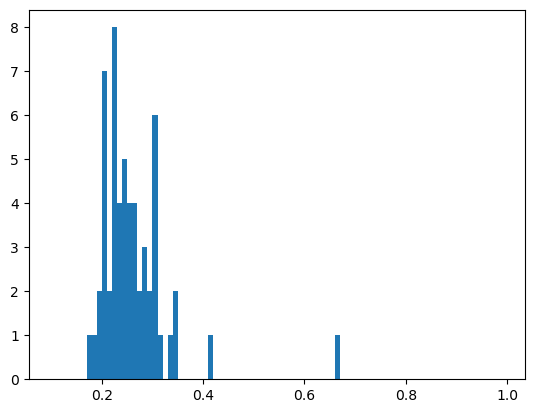

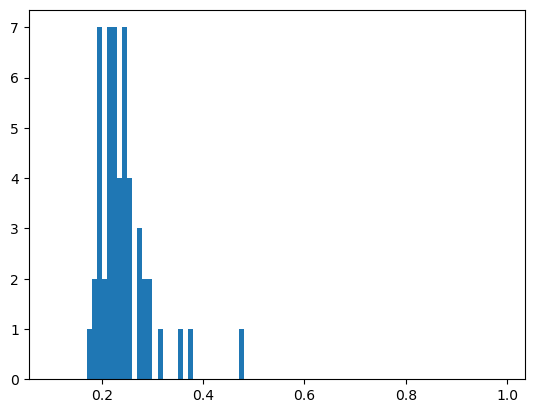

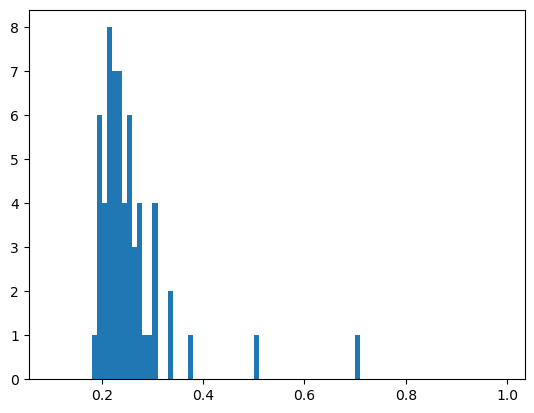

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(df[1]["Prob"], bins=np.arange(0.1, 1.0, 0.01))
plt.show()
plt.hist(df[2]["Prob"], bins=np.arange(0.1, 1.0, 0.01))
plt.show()
plt.hist(df[3]["Prob"], bins=np.arange(0.1, 1.0, 0.01))
plt.show()

In [20]:
means, stds, bounds = [], [], []
for i in range(3):
    X = df[i + 1]["Prob"]
    means.append(X.mean())
    stds.append(X.std())
    bounds.append(means[i] + 3 * stds[i])

means, stds, bounds

([0.25649122807017544, 0.2369230769230769, 0.250327868852459],
 [0.07172594738880801, 0.05237640770866741, 0.07803775182808968],
 [0.4716690702365995, 0.3940523000490791, 0.48444112433672804])

In [23]:
bound = max(bounds)
bound

0.48444112433672804

In [28]:
all_mutations = pd.concat([df[1], df[2], df[3]], axis=0)
all_mutations.sort_values("Pos", inplace=True)
all_mutations.head(20)

,Pos,Ref,Alt,Prob,Pval
0,38,T,C,0.66,0.000197
0,38,T,C,0.70,0.000197
1,44,T,C,0.50,0.000421
0,44,T,C,0.47,0.000734
1,54,T,C,0.30,0.007270
2,72,A,G,0.30,0.000930
3,95,A,G,0.24,0.006887
2,95,A,G,0.24,0.005633
3,105,A,G,0.25,0.004707
4,117,C,T,0.30,0.000151


In [47]:
pos = []

for i in range(3):
#     pos.append(set(zip(df[i + 1]["Pos"], df[i + 1]["Ref"], df[i + 1]["Alt"])))
    pos.append(set(df[i + 1]["Pos"]))


upstream_errors = pos[0] & pos[1] & pos[2]
unique_errors = pos[0] ^ pos[1] ^ pos[2] ^ upstream_errors
two_times_errors = pos[0] | pos[1] | pos[2] - upstream_errors - unique_errors
len(upstream_errors), len(unique_errors), len(two_times_errors)

(33, 33, 75)

In [48]:
unique_errors

{54,
 72,
 105,
 117,
 133,
 193,
 199,
 228,
 230,
 271,
 328,
 398,
 403,
 426,
 548,
 591,
 595,
 759,
 774,
 793,
 898,
 1008,
 1100,
 1105,
 1209,
 1260,
 1286,
 1301,
 1339,
 1517,
 1520,
 1591,
 1600}

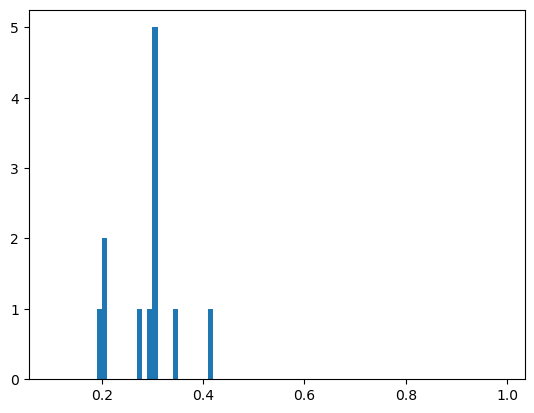

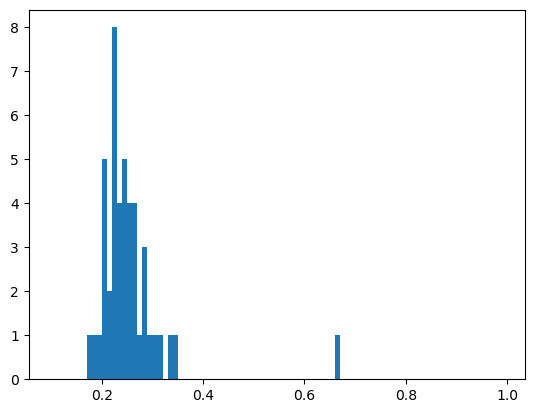

In [51]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(df[1].loc[df[1]["Pos"].isin(unique_errors), "Prob"], bins=np.arange(0.1, 1.0, 0.01))
plt.show()
plt.hist(df[1].loc[~df[1]["Pos"].isin(unique_errors), "Prob"], bins=np.arange(0.1, 1.0, 0.01))
plt.show()
# plt.hist(df[2]["Prob"], bins=np.arange(0.1, 1.0, 0.01))
# plt.show()
# plt.hist(df[3]["Prob"], bins=np.arange(0.1, 1.0, 0.01))
# plt.show()